<a href="https://colab.research.google.com/github/MaslovAleksey/Image_clustering/blob/main/Image_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1.) Project description**

* ## **The task:**
> #### Divide images on 983 clusters, including 7-10 images.

---

* ## **Libraries and modules used:**
> #### torch, numpy, Image, matplotlib, os, colab, clip, PCA.

---

* ## **Training data:**
> #### 1.   Data set consists of 9605 images. Each image is uniquely by its name and strictly refers to one cluster;
> #### 2.   Each cluster includes 7-10 images;;
> #### 3.   Images are pre-processed.

---

* ## **Features of the algorithm implementation:**
> #### 1.   Algorithm was implement by *PyTorch*;
> #### 2.   Using the *clip* model to extract image features;
> #### 3.   Calculations were made using *CUDA* (*torch.device("cuda"*));
> #### 3.   The size of the image fuature vector has been reduced from 512 to 100 using *PCA*;
> #### 4.   Image clustering was implement using *KMeansConstrained*.



# **2.) Connecting the necessary libraries**

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import random
import os
import zipfile
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

In [ ]:
# CLIP model and k_means_constrained installation
! pip install git+https://github.com/openai/CLIP.git
! pip install k_means_constrained

In [4]:
import torch
import clip
from k_means_constrained import KMeansConstrained

# **3.) Implementation of necessary classes**

## **ImageLoader**

In [5]:
class ImageLoader():
  def __init__(self, base_path):
    self.base_path = base_path

  def load_images(self, zipfile_path):
    with zipfile.ZipFile(zipfile_path,"r") as zip_ref:
        zip_ref.extractall(self.base_path)

  def show_images(self, num_imgs):
    base_pass = self.base_path + '/dataset'
    image_names = os.listdir(base_pass)
    fig, ax = plt.subplots(nrows=1, ncols=num_imgs, figsize=(20,7))
    fig.suptitle("Исходные изображения", size=25, y=0.8)
    for i in range (num_imgs):
      image_name = random.choice(image_names)
      img_path = base_pass + '/' + image_name
      img = Image.open(img_path)
      ax[i].imshow(img)
      ax[i].axes.xaxis.set_ticks([]) # инициализация тиков и меток оси пустым списком
      ax[i].get_yaxis().set_visible(False)
      ax[i].set_xlabel(image_name.replace(".png", ""), size=14)
    plt.show()
    return image_names

## **ImagePreprocessor**

In [6]:
class ImagePreprocessor():
  def __init__(self, base_path, device):
    self.device = device
    self.base_path = base_path
    self.model, self.preprocess = clip.load("ViT-B/32", device=device)

  # Image features extraction
  def get_image_features(self, image_names):
    base_pass = self.base_path + '/dataset'
    num_images = len(image_names)
    data_features = []
    for i in range(num_images):
      img_path = base_pass + '/' + image_names[i]
      img_data = Image.open(img_path)
      img_data = self.preprocess(img_data).unsqueeze(0).to(self.device)
      with torch.no_grad():
        img_features = self.model.encode_image(img_data).detach().cpu().numpy()
      data_features.append(img_features)
    return np.array(data_features).squeeze()

  # Linear dimensionality reduction
  def dim_reduction(self, data_features, n_components):
    pca = PCA(n_components)
    pca.fit(data_features)
    pca_features = pca.transform(data_features)
    return pca_features

## **ImageClusterizer**

In [33]:
class ImageClusterizer():
  def __init__(self, base_path, n_clusters, size_min, size_max):
      self.base_path = base_path
      self.model = KMeansConstrained(
      n_clusters=n_clusters,
      size_min=size_min,
      size_max=size_max
      )

  def clustering(self, pca_features):
    self.model.fit(data_features)
    labels = self.model.labels_
    return labels

  def create_clusters_dict(self, labels, image_names):
    clusters_dict = {}
    for (i,lbl) in enumerate(labels):
      if (lbl not in clusters_dict):
        clusters_dict[lbl] = []
      clusters_dict[lbl].append(image_names[i])
    return clusters_dict

  def show_clusters(self, numb_clstr, clusters_dict):
    base_pass = self.base_path + '/dataset'
    image_names = clusters_dict[numb_clstr]
    k = len(image_names)
    fig, ax = plt.subplots(nrows=1, ncols=k, figsize=(20,7))
    fig.suptitle(f"Cluster №{numb_clstr+1}", size=25, y=0.7)
    for i in range (k):
      image_name = image_names[i]
      img_path = base_pass + '/' + image_name
      img = Image.open(img_path)
      ax[i].imshow(img)
      ax[i].axes.xaxis.set_ticks([]) # Initializing ticks and axis labels as an empty list
      ax[i].get_yaxis().set_visible(False)
      ax[i].set_xlabel(image_name.replace(".png", ""), size=14)
    plt.show()

  def save_results(self, saved_path, labels, image_names):
    clusters_df = pd.DataFrame({'filename':image_names, 'label':labels})
    clusters_df = clusters_df.sort_values(by = ["filename"])
    clusters_df.to_csv(saved_path, index=False)
    return clusters_df

# **4.) Implementing image clustering**

## **Image demonstration**

In [7]:
base_path = "/content/image_data"
image_loader = ImageLoader(base_path)

In [8]:
zipfile_path = "/content/drive/MyDrive/Colab Notebooks/Machine learning/Яндекс. /Code Run/Machine learning/data/Звёздные карты 2.0 /dataset.zip"
image_loader.load_images(zipfile_path)

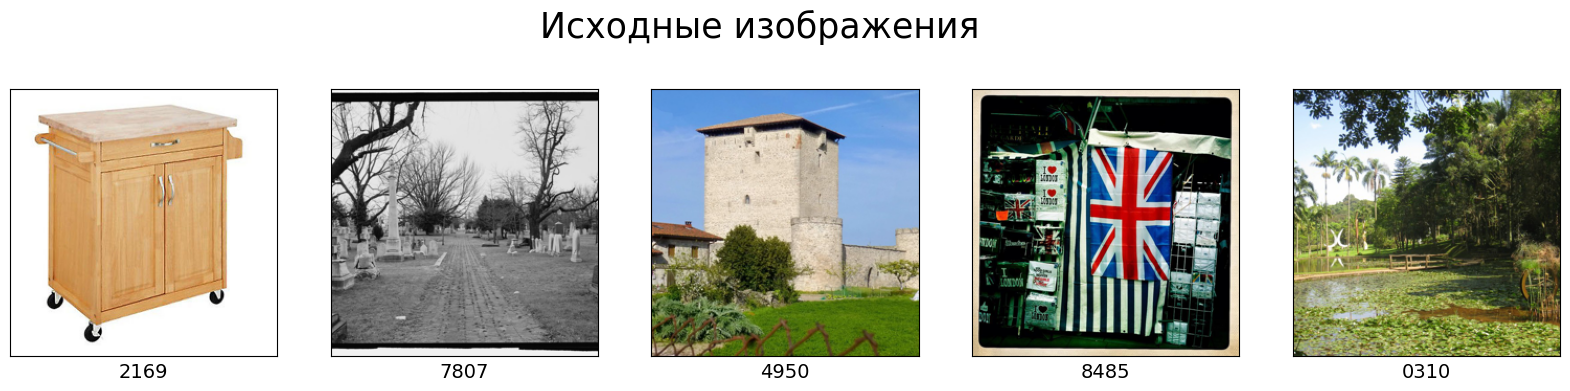

In [9]:
num_imgs = 5
image_names = image_loader.show_images(num_imgs)

## **Image pre-processing**

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_preprocessor = ImagePreprocessor(base_path, device)

100%|███████████████████████████████████████| 338M/338M [02:31<00:00, 2.34MiB/s]


In [11]:
data_features = image_preprocessor.get_image_features(image_names)

In [13]:
n_components = 100
pca_features = image_preprocessor.dim_reduction(data_features, n_components)

## **Image clustering**

In [34]:
n_clusters = 983
size_min = 7
size_max = 10
image_clusterizer = ImageClusterizer(base_path, n_clusters, size_min, size_max)

In [18]:
labels = image_clusterizer.clustering(pca_features)

In [19]:
clusters_dict = image_clusterizer.create_clusters_dict(labels, image_names)

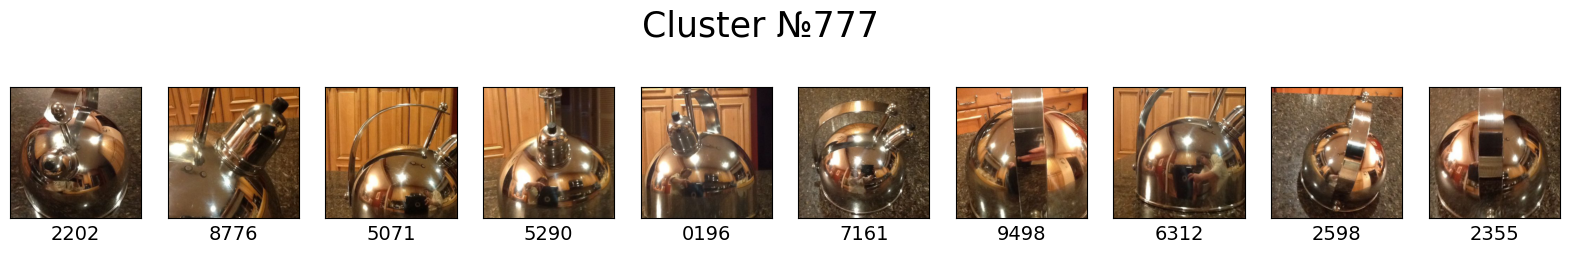

In [40]:
numb_clstr = 776
image_clusterizer.show_clusters(numb_clstr, clusters_dict)

In [32]:
saved_path = "/content/drive/MyDrive/Colab Notebooks/Machine learning/Яндекс. /Code Run/Machine learning/data/Звёздные карты 2.0 /clusters_constrained.csv"
clusters_df = image_clusterizer.save_results(saved_path, labels, image_names)

# **5.) Work conclusions**

> #### 1.   The *PCA* connection must be made before installing the *CLIP* model, as setting *CLIP* model changes *Numpy* version.
> #### 2.   The *preprocess* module from *CLIP (ВиТ-Б/32)* model allows you to preprocess both white and black and color images.
> #### 3.   Clustering using *KMeansConstrained* takes longer than clustering using *KMeans*.



